<a href="https://colab.research.google.com/github/ZeroToH3ro/Predictive-Model-Advance/blob/main/Predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.base")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.decomposition._base")


In [19]:
def sequence_to_features(seq, seq_type="dna"):
    if seq is None or (isinstance(seq, float) and np.isnan(seq)):
        seq = ""
    else:
        seq = str(seq)

    base_dict = {
        "A": 1, "C": 2, "G": 3, "T": 4,
        "N": 0, "-": 0,
        "R": 5, "Y": 6, "M": 7, "K": 8,
        "S": 9, "W": 10, "H": 11, "B": 12,
        "V": 13, "D": 14,
    }

    aa_dict = {
        "A": 1, "R": 2, "N": 3, "D": 4, "C": 5,
        "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10,
        "L": 11, "K": 12, "M": 13, "F": 14, "P": 15,
        "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20,
        "-": 0, "X": 0,
    }

    if seq_type == "dna":
        return [base_dict.get(base, 0) for base in seq]
    if seq_type == "aa":
        return [aa_dict.get(aa, 0) for aa in seq]

    raise ValueError("seq_type must be either dna or aa")


def pad_sequences_2d(seqs, max_len, pad_value=0):
    padded = np.full((len(seqs), max_len), pad_value, dtype=int)
    for i, seq in enumerate(seqs):
        if not seq:
            continue
        trunc = seq[:max_len]
        padded[i, :len(trunc)] = trunc
    return padded


def encode_sequence_columns(data, seq_cols, seq_type):
    sequences = data[seq_cols].fillna("").astype(str).values
    encoded = [[sequence_to_features(seq, seq_type=seq_type) for seq in row] for row in sequences]
    max_len = max((len(seq) for row in encoded for seq in row), default=0)
    if max_len == 0:
        raise ValueError("No sequence data found in the selected columns.")
    padded = np.array([pad_sequences_2d(row, max_len, pad_value=0) for row in encoded])
    return padded


class FiniteClipper(BaseEstimator, TransformerMixin):
    def __init__(self, clip_min=-10.0, clip_max=10.0):
        self.clip_min = clip_min
        self.clip_max = clip_max

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        return np.clip(X, self.clip_min, self.clip_max)


In [20]:
def load_sequence_data(data_path, seq_type="aa"):
    if str(data_path).lower().endswith(".csv"):
        data = pd.read_csv(data_path)
        if "Accession number" not in data.columns:
            data = pd.read_csv(data_path, skiprows=2)
    else:
        data = pd.read_excel(data_path)

    seq_columns_map = {
        "aa": ["NS3_aa", "NS5A_aa", "NS5B_aa"],
        "dna": ["NS3_Nu", "NS5A_Nu", "NS5B_Nu"],
    }
    if seq_type not in seq_columns_map:
        raise ValueError("seq_type must be aa or dna")

    seq_cols = seq_columns_map[seq_type]
    missing = [col for col in seq_cols if col not in data.columns]
    if missing:
        raise ValueError(f"Missing sequence columns: {missing}. Available columns: {list(data.columns)}")

    X_seq = encode_sequence_columns(data, seq_cols, seq_type=seq_type)
    return data, X_seq


def build_target(response_series):
    response_map = {
        "Yes": 0,
        "No": 1,
        "SVR": 0,
        "Non SVR": 1,
        "Non-SVR": 1,
    }
    response_series = response_series.astype(str).str.strip()
    y = response_series.map(response_map)
    if y.isna().any():
        bad_values = sorted(response_series[y.isna()].unique())
        raise ValueError(f"Unmapped Respond values: {bad_values}")
    return y.values


In [21]:
def count_mutations(value):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return 0
    value = str(value).strip()
    if value == "" or value.lower() in {"none", "not available", "na", "-", "nan"}:
        return 0
    parts = [p.strip() for p in value.split(",")]
    parts = [p for p in parts if p and p.lower() not in {"none", "not available", "na", "-", "nan"}]
    return len(parts)


def load_ras_features(ras_path, sheet_name="Sheet1"):
    ras = pd.read_excel(ras_path, sheet_name=sheet_name)
    ras["Accession number"] = ras["Accession number"].astype(str).str.strip()

    numeric_cols = ras.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in {"No", "id"}]
    numeric_df = ras[numeric_cols].copy() if numeric_cols else pd.DataFrame(index=ras.index)

    genotype_df = (
        pd.get_dummies(ras["Genotype"].fillna("Unknown"), prefix="Genotype")
        if "Genotype" in ras.columns
        else pd.DataFrame(index=ras.index)
    )

    mutation_cols = [
        c for c in ras.columns
        if c.endswith("_muts") or c.startswith("all_mutations_") or c.startswith("all_resistance_muts_")
    ]
    mutation_counts = (
        pd.DataFrame({f"{c}_count": ras[c].apply(count_mutations) for c in mutation_cols})
        if mutation_cols
        else pd.DataFrame(index=ras.index)
    )

    features = pd.concat([ras[["Accession number"]], numeric_df, genotype_df, mutation_counts], axis=1)
    return features.fillna(0)


def build_feature_matrix(sequence_path, ras_path, seq_type="aa", ras_sheet="Sheet1"):
    seq_df, X_seq = load_sequence_data(sequence_path, seq_type=seq_type)
    seq_df["Accession number"] = seq_df["Accession number"].astype(str).str.strip()

    ras_features = load_ras_features(ras_path, sheet_name=ras_sheet)
    ras_features["Accession number"] = ras_features["Accession number"].astype(str).str.strip()

    common_mask = seq_df["Accession number"].isin(ras_features["Accession number"])
    if not common_mask.all():
        seq_df = seq_df.loc[common_mask].reset_index(drop=True)
        X_seq = X_seq[common_mask.values]

    ras_features = ras_features.set_index("Accession number").loc[seq_df["Accession number"]].reset_index()

    X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)
    ras_cols = [c for c in ras_features.columns if c != "Accession number"]
    X_ras = ras_features[ras_cols].to_numpy()
    X = np.hstack([X_seq_flat, X_ras]).astype(float)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    y = build_target(seq_df["Respond"])

    feature_names = [f"seq_{i}" for i in range(X_seq_flat.shape[1])] + ras_cols
    return X, y, seq_df, ras_features, feature_names


In [22]:
def optimize_threshold(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    finite_mask = np.isfinite(thresholds)
    if finite_mask.any():
        thresholds = thresholds[finite_mask]
        fpr = fpr[finite_mask]
        tpr = tpr[finite_mask]
    else:
        return 0.5, fpr, tpr

    youden = tpr - fpr
    best_idx = np.argmax(youden)
    return thresholds[best_idx], fpr, tpr


def plot_roc_curve(fpr, tpr, auc_score, label):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=3, label=f"{label} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], "k--", linewidth=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [23]:
def train_and_evaluate_models(X, y, seq_df, feature_names, label="", save_path=None, include_xgboost=True):
    try:
        from xgboost import XGBClassifier
        has_xgb = True
    except ImportError:
        has_xgb = False
        if include_xgboost:
            print("xgboost not installed; skipping XGBoost model.")

    if save_path is None:
        save_path = os.path.join(os.getcwd(), "ml_results")
    os.makedirs(save_path, exist_ok=True)

    print(f"Label: {label}")
    print("Class distribution:", pd.Series(y).value_counts().to_dict())

    indices = np.arange(len(y))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, indices, test_size=0.4, random_state=42, stratify=y
    )

    base_steps = [
        ("var", VarianceThreshold()),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("finite", FiniteClipper()),
    ]

    models = [
        {
            "name": "SVM",
            "estimator": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
            "param_grid": {
                "model__C": [0.1, 1, 10],
                "model__gamma": ["scale", 0.1, 0.01],
            },
            "extra_steps": [("pca", PCA(n_components=0.95, svd_solver="full", random_state=42))],
        },
        {
            "name": "Elastic Net",
            "estimator": LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                max_iter=5000,
                class_weight="balanced",
            ),
            "param_grid": {
                "model__C": [0.01, 0.1, 1, 10],
                "model__l1_ratio": [0.1, 0.5, 0.9],
            },
        },
        {
            "name": "Random Forest",
            "estimator": RandomForestClassifier(random_state=42, class_weight="balanced"),
            "param_grid": {
                "model__n_estimators": [300, 500],
                "model__max_depth": [None, 20],
                "model__min_samples_leaf": [1, 2],
            },
        },
        {
            "name": "GBM",
            "estimator": GradientBoostingClassifier(random_state=42),
            "param_grid": {
                "model__n_estimators": [200, 400],
                "model__learning_rate": [0.05, 0.1],
                "model__max_depth": [2, 3],
            },
        },
        {
            "name": "Decision Tree",
            "estimator": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
            "param_grid": {
                "model__max_depth": [3, 5, None],
                "model__min_samples_leaf": [1, 2],
            },
        },
    ]

    if include_xgboost and has_xgb:
        pos = y_train.sum()
        neg = len(y_train) - pos
        scale_pos_weight = float(neg) / pos if pos > 0 else 1.0
        models.append({
            "name": "XGBoost",
            "estimator": XGBClassifier(
                random_state=42,
                eval_metric="logloss",
                tree_method="hist",
                scale_pos_weight=scale_pos_weight,
            ),
            "param_grid": {
                "model__n_estimators": [300, 500],
                "model__learning_rate": [0.05, 0.1],
                "model__max_depth": [3, 5],
                "model__subsample": [0.8, 1.0],
                "model__colsample_bytree": [0.8, 1.0],
            },
        })

    metrics = []
    preds_df = pd.DataFrame({
        "Accession number": seq_df.iloc[idx_test]["Accession number"].values,
        "True_Label": y_test,
    })
    model_results = {}

    for cfg in models:
        print(f"\nTraining {cfg['name']}...")
        steps = list(base_steps)
        if cfg.get("extra_steps"):
            steps.extend(cfg["extra_steps"])
        steps.append(("model", cfg["estimator"]))

        pipeline = Pipeline(steps=steps)
        search = GridSearchCV(pipeline, cfg["param_grid"], scoring="roc_auc", cv=5, n_jobs=-1)
        search.fit(X_train, y_train)

        model = search.best_estimator_
        print(f"Best params for {cfg['name']}: {search.best_params_}")
        print(f"Best CV ROC-AUC: {search.best_score_:.4f}")

        y_proba = model.predict_proba(X_test)[:, 1]
        threshold, fpr, tpr = optimize_threshold(y_test, y_proba)
        y_pred = (y_proba >= threshold).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_proba)

        metrics.append({
            "Model": cfg["name"],
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1_Score": f1,
            "AUC_Score": auc_score,
            "Threshold": threshold,
        })

        col_base = cfg["name"].replace(" ", "_")
        preds_df[f"Pred_{col_base}"] = y_pred
        preds_df[f"Prob_{col_base}"] = np.round(y_proba * 100, 2)

        model_results[cfg["name"]] = {
            "model": model,
            "threshold": threshold,
            "metrics": metrics[-1],
            "fpr": fpr,
            "tpr": tpr,
            "y_pred": y_pred,
            "y_proba": y_proba,
        }

        if cfg["name"] == "SVM":
            print(f"Optimal threshold (Youden): {threshold:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"AUC Score: {auc_score:.4f}")
            print("Confusion matrix:")
            print(confusion_matrix(y_test, y_pred))
            plot_roc_curve(fpr, tpr, auc_score, label=label or cfg["name"])

    label_map = {0: "Success", 1: "Failure"}
    preds_df["True_Label"] = preds_df["True_Label"].map(label_map)
    for col in preds_df.columns:
        if col.startswith("Pred_"):
            preds_df[col] = preds_df[col].map({0: "Success", 1: "Failure"})

    preds_path = os.path.join(save_path, f"ensemble_predictions_{label}.xlsx")
    preds_df.to_excel(preds_path, index=False)

    metrics_df = pd.DataFrame(metrics)
    metrics_path = os.path.join(save_path, f"model_metrics_{label}.xlsx")
    metrics_df.to_excel(metrics_path, index=False)

    svm_metrics = metrics_df[metrics_df["Model"] == "SVM"].drop(columns=["Model"], errors="ignore")
    if not svm_metrics.empty:
        svm_metrics.to_excel(os.path.join(save_path, f"svm_metrics_{label}.xlsx"), index=False)

    other_metrics = metrics_df[metrics_df["Model"] != "SVM"]
    if not other_metrics.empty:
        other_metrics.to_excel(os.path.join(save_path, f"model_metrics_{label}_others.xlsx"), index=False)

    if {"Prob_SVM", "Pred_SVM"}.issubset(set(preds_df.columns)):
        svm_df = preds_df[["Accession number", "True_Label", "Prob_SVM", "Pred_SVM"]].rename(columns={
            "Prob_SVM": "Predicted_Failure_Probability(%)",
            "Pred_SVM": "Predicted_Label",
        })
        svm_df.to_excel(os.path.join(save_path, f"svm_predictions_{label}.xlsx"), index=False)

    return {
        "models": model_results,
        "metrics": metrics_df,
        "predictions": preds_df,
        "X_train": X_train,
        "X_test": X_test,
        "y_test": y_test,
        "feature_names": feature_names,
        "save_path": save_path,
    }


In [24]:
def explain_with_shap(model, X_train, X_test, feature_names, max_background=50, max_samples=20):
    try:
        import shap
    except ImportError:
        print("SHAP not installed; skipping explainability.")
        return

    rng = np.random.RandomState(42)
    bg_size = min(max_background, len(X_train))
    sample_size = min(max_samples, len(X_test))

    background = X_train[rng.choice(len(X_train), size=bg_size, replace=False)]
    samples = X_test[:sample_size]

    print("Running SHAP on a small sample for explainability...")
    explainer = shap.KernelExplainer(model.predict_proba, background)
    shap_values = explainer.shap_values(samples, nsamples=100)

    if isinstance(shap_values, list):
        shap_matrix = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    else:
        shap_matrix = shap_values
        if shap_matrix.ndim == 3:
            shap_matrix = shap_matrix[:, :, 1] if shap_matrix.shape[-1] > 1 else shap_matrix[:, :, 0]

    # Some SHAP versions include a final bias column; drop if present.
    if shap_matrix.shape[1] == samples.shape[1] + 1:
        shap_matrix = shap_matrix[:, :-1]

    if shap_matrix.shape[0] != samples.shape[0] and shap_matrix.shape[1] == samples.shape[0]:
        shap_matrix = shap_matrix.T

    if shap_matrix.shape[1] != samples.shape[1]:
        print("SHAP output shape does not match input features; skipping plot.")
        return

    if len(feature_names) != samples.shape[1]:
        feature_names = [f"feature_{i}" for i in range(samples.shape[1])]

    shap.summary_plot(shap_matrix, samples, feature_names=feature_names, show=True)


In [25]:
def plot_model_comparisons(results, label="", save_path=None):
    metrics_df = results.get("metrics")
    model_results = results.get("models", {}) if results else {}

    if metrics_df is None or len(metrics_df) == 0:
        print("No metrics available to plot.")
        return

    metric_cols = [
        "AUC_Score",
        "F1_Score",
        "Accuracy",
        "Precision",
        "Recall",
    ]
    metric_cols = [m for m in metric_cols if m in metrics_df.columns]
    safe_label = (label or "run").replace(" ", "_")

    if metric_cols:
        x = np.arange(len(metrics_df))
        width = 0.8 / len(metric_cols)
        plt.figure(figsize=(12, 6))
        for i, metric in enumerate(metric_cols):
            plt.bar(x + i * width, metrics_df[metric], width=width, label=metric)
        plt.xticks(x + width * (len(metric_cols) - 1) / 2, metrics_df["Model"], rotation=30, ha="right")
        plt.ylabel("Score")
        plt.title(f"Model performance comparison ({label})" if label else "Model performance comparison")
        plt.ylim(0, 1)
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, f"model_metric_comparison_{safe_label}.png"), dpi=200)
        plt.show()
    else:
        print("No metric columns found for plotting.")

    plt.figure(figsize=(8, 6))
    roc_plotted = False
    for name, res in model_results.items():
        fpr, tpr = res.get("fpr"), res.get("tpr")
        if fpr is None or tpr is None:
            continue
        auc_val = None
        if isinstance(res.get("metrics"), dict):
            auc_val = res["metrics"].get("AUC_Score")
        label_str = f"{name} (AUC = {auc_val:.2f})" if auc_val is not None else name
        plt.plot(fpr, tpr, linewidth=2, label=label_str)
        roc_plotted = True

    if roc_plotted:
        plt.plot([0, 1], [0, 1], "k--", linewidth=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC comparison ({label})" if label else "ROC comparison")
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, f"roc_comparison_{safe_label}.png"), dpi=200)
        plt.show()
    else:
        plt.close()
        print("No ROC data available to plot.")


Label: AA+RAS
Class distribution: {0: 101, 1: 61}

Training SVM...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is p

Best params for SVM: {'model__C': 0.1, 'model__gamma': 'scale'}
Best CV ROC-AUC: 0.8217
Optimal threshold (Youden): 0.4783
Accuracy: 0.3692
Precision: 0.3692
Recall: 1.0000
F1 Score: 0.5393
AUC Score: 0.1255
Confusion matrix:
[[ 0 41]
 [ 0 24]]


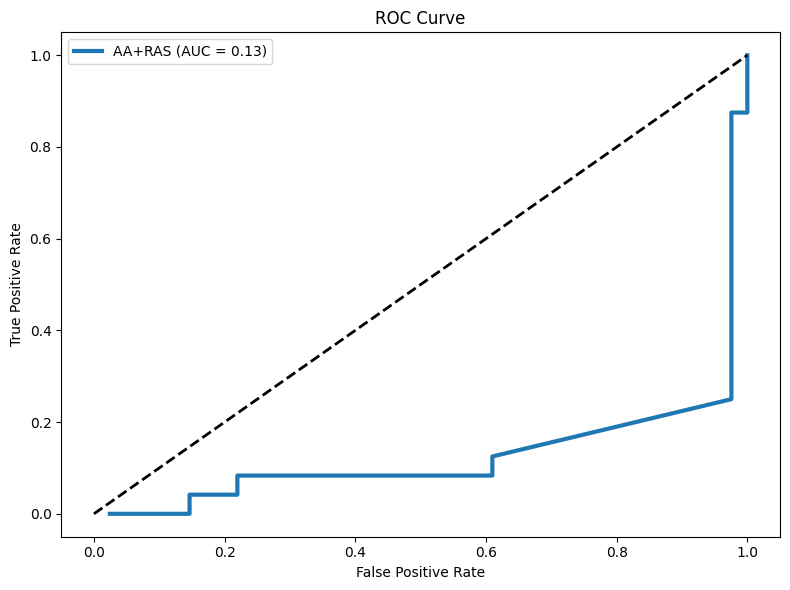


Training Elastic Net...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is p

Best params for Elastic Net: {'model__C': 10, 'model__l1_ratio': 0.9}
Best CV ROC-AUC: 0.8696

Training Random Forest...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/

Best params for Random Forest: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 300}
Best CV ROC-AUC: 0.8973

Training GBM...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is p

Best params for GBM: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.8613

Training Decision Tree...
Best params for Decision Tree: {'model__max_depth': 3, 'model__min_samples_leaf': 1}
Best CV ROC-AUC: 0.7369

Training XGBoost...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is p

Best params for XGBoost: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best CV ROC-AUC: 0.8574


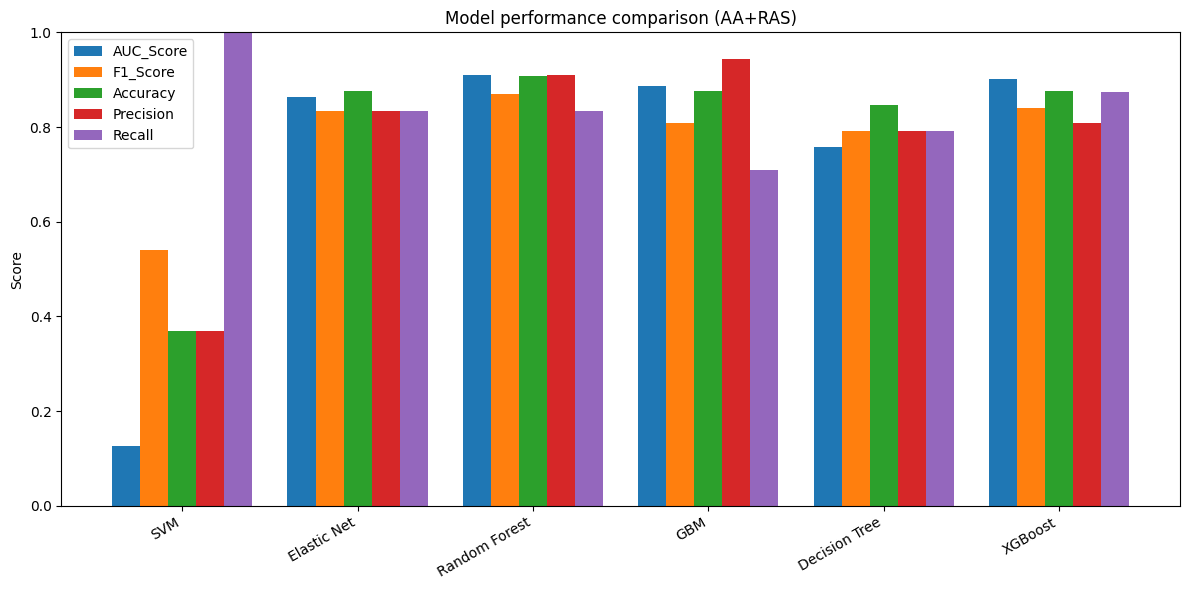

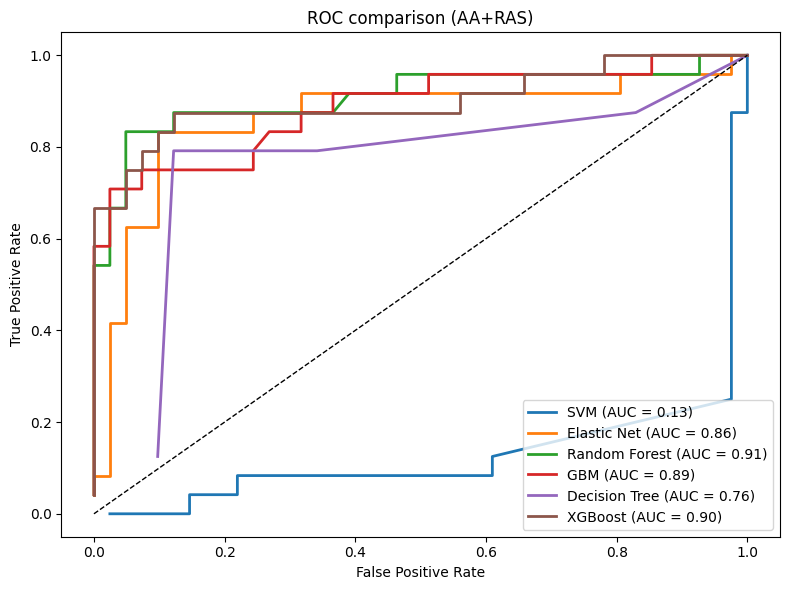

Running SHAP on a small sample for explainability...


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: divide by zero encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: overflow encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: invalid value encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: divide by zero encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: overfl

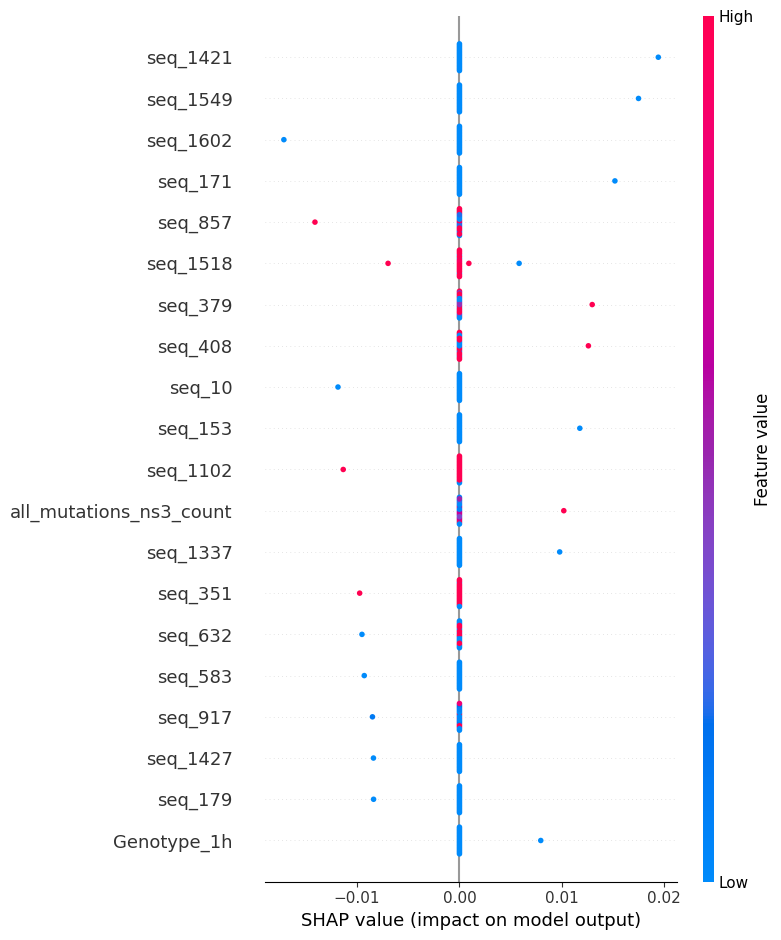

In [26]:
sequence_path = "data/data_training_162_model.csv"
ras_path = "data/data_RAS.xlsx"
seq_type = "aa"  # amino-acid genomic features

run_dir = os.path.join("outputs", "Experiment_Model_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

X, y, seq_df, ras_features, feature_names = build_feature_matrix(
    sequence_path,
    ras_path,
    seq_type=seq_type,
    ras_sheet="Sheet1",
)

results = train_and_evaluate_models(
    X,
    y,
    seq_df=seq_df,
    feature_names=feature_names,
    label=f"{seq_type.upper()}+RAS",
    save_path=run_dir,
)

plot_model_comparisons(
    results,
    label=f"{seq_type.upper()}+RAS",
    save_path=run_dir,
)

svm_result = results["models"].get("SVM") if results.get("models") else None
if svm_result:
    explain_with_shap(
        svm_result["model"],
        results["X_train"],
        results["X_test"],
        feature_names=results["feature_names"],
    )
else:
    print("SVM results unavailable; skipping SHAP explainability.")
